# <font color='red'>Definitions</font>

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# <font color='red'>Boson with $U/t = 10$</font>

## <font color='blue'>Parameters</font>

In [47]:
L = 64
N = 64
t = 1.0
U = 10.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [48]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [49]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("cd", [i, i+1], -t)
    os.add_term("cd", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [50]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.458 | E =       4.4703892802 | DW = 9.74953e-11

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.811 | E =      -9.4677147616 | DE = -1.39e+01 | DW = 1.93027e-10

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      3.830 | E =     -15.3477533719 | DE = -5.88e+00 | DW = 4.89505e-10

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.703 | E =     -24.8014858787 | DE = -9.45e+00 | DW = 2.04468e-11

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      5.035 | E =     -24.9178072681 | DE = -1.16e-01 | DW = 2.21540e-15

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

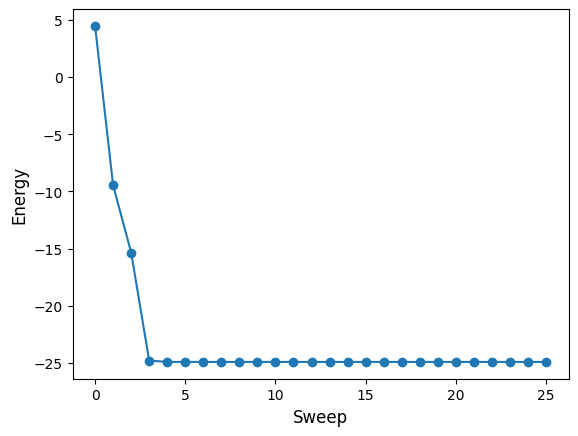

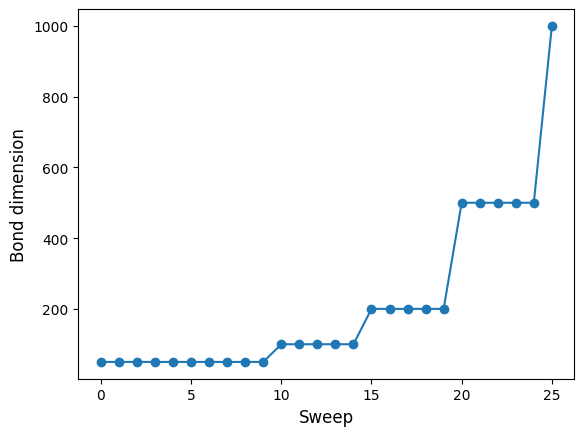

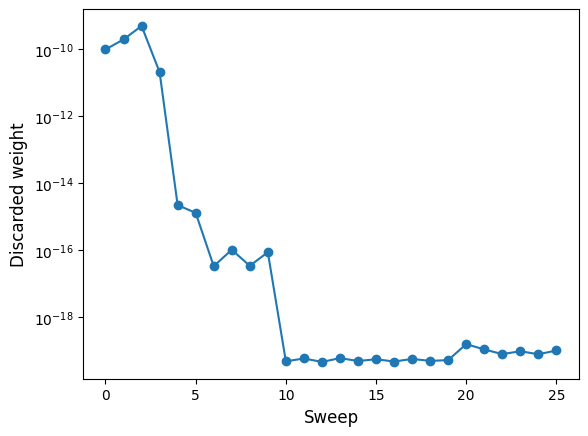

In [51]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

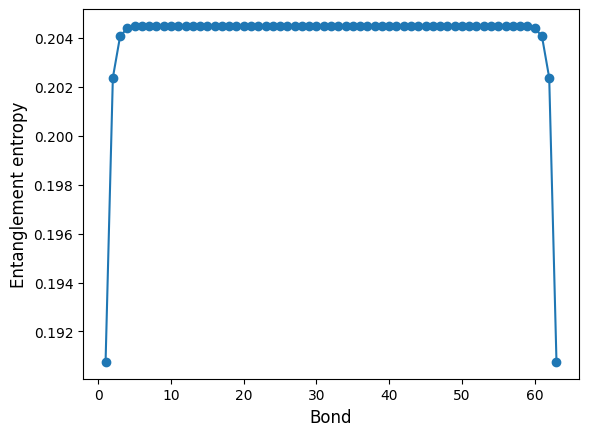

In [52]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [53]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='cd', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 64.00000000000082
Elapsed time: 1.5616140365600586 seconds


### Site occupations

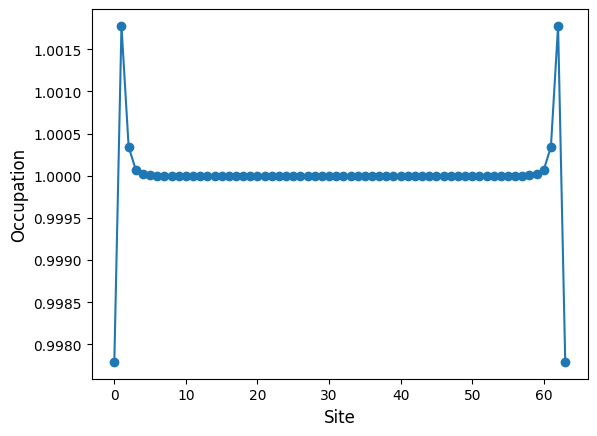

In [54]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

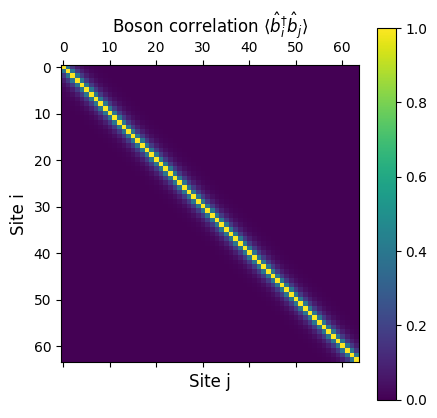

In [55]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

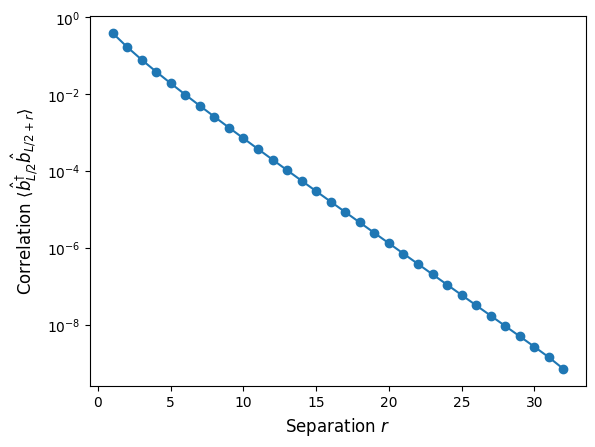

In [56]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### Momentum distribution

Total number = 64.00000000000084


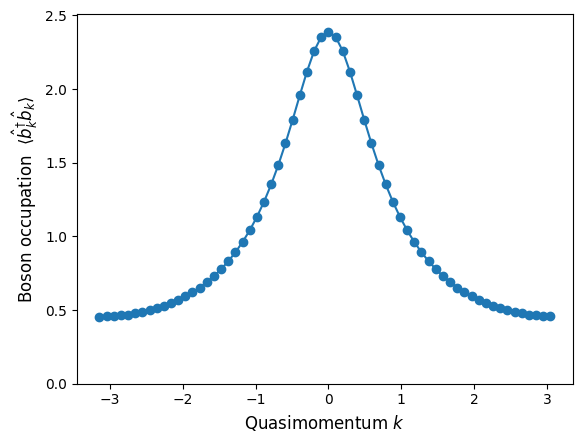

In [57]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

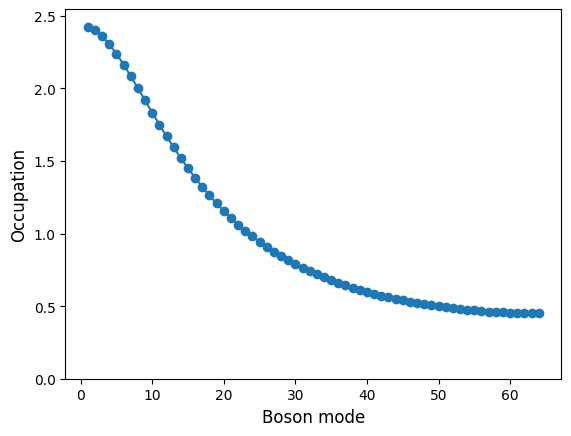

In [58]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(np.arange(1,L+1), bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [59]:
start_time = time.time()

ndist = []
for n in range(nmax+1):
    weights = driver.get_npdm(mps, npdm_expr=proj_keys[n], fermionic_ops='', mask=[0])[0]
    ndist.append(weights)
ndist = np.array(ndist).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 1.0243695209072137e-13
Elapsed time: 2.247896194458008 seconds


### Site-averaged number distribution

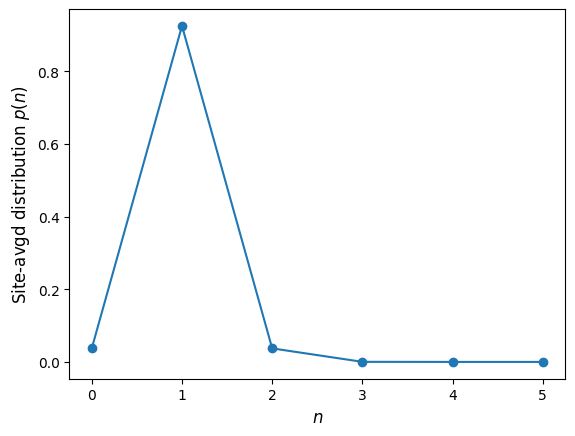

In [60]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuation

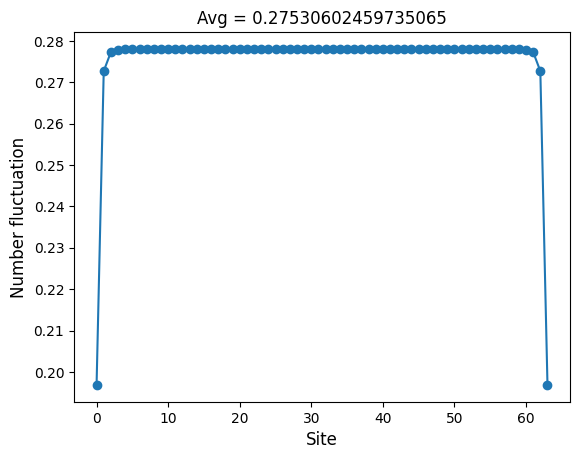

In [61]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [62]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='cdcd', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.2753060245973507
Elapsed time: 1.3159968852996826 seconds


### Correlation matrix

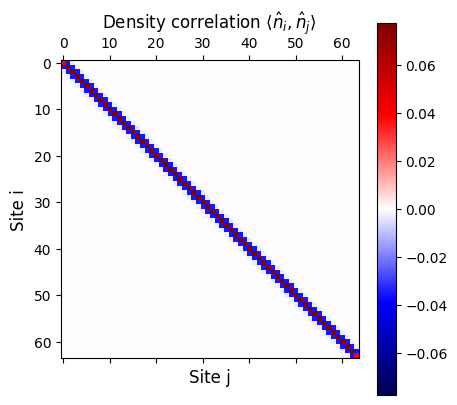

In [63]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

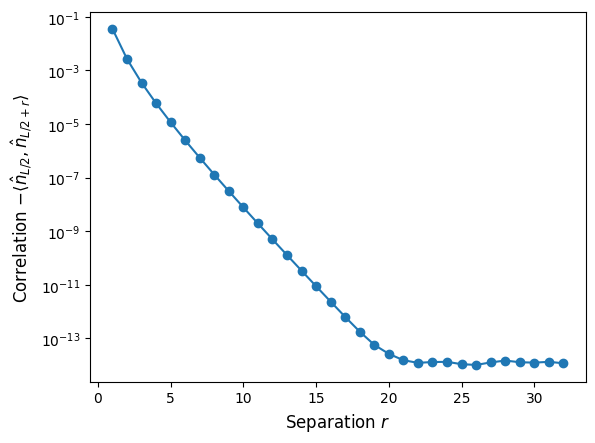

In [64]:
plt.plot(np.arange(1,L//2+1), -densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

# <font color='red'>Boson with $U/t = 2$</font>

## <font color='blue'>Parameters</font>

In [22]:
L = 64
N = 64
t = 1.0
U = 2.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [23]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [24]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("cd", [i, i+1], -t)
    os.add_term("cd", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [25]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.495 | E =     -82.2895779752 | DW = 4.72012e-11

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.855 | E =     -83.9673323360 | DE = -1.68e+00 | DW = 1.27612e-08

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      3.958 | E =     -84.4881672715 | DE = -5.21e-01 | DW = 3.92440e-08

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      5.254 | E =     -84.6650055667 | DE = -1.77e-01 | DW = 2.04898e-08

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      7.112 | E =     -84.6917748454 | DE = -2.68e-02 | DW = 7.16430e-08

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

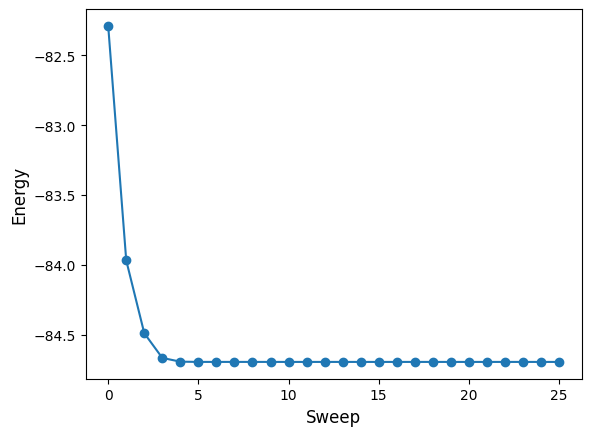

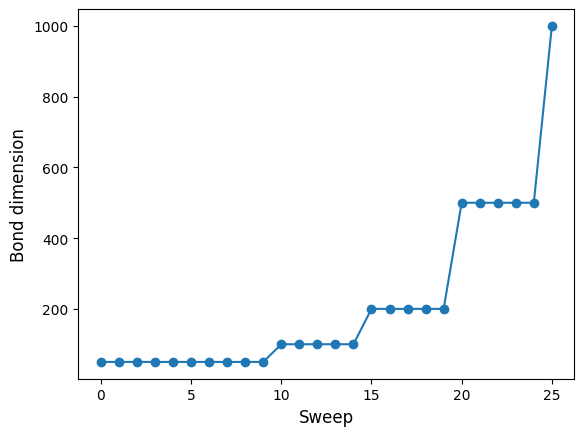

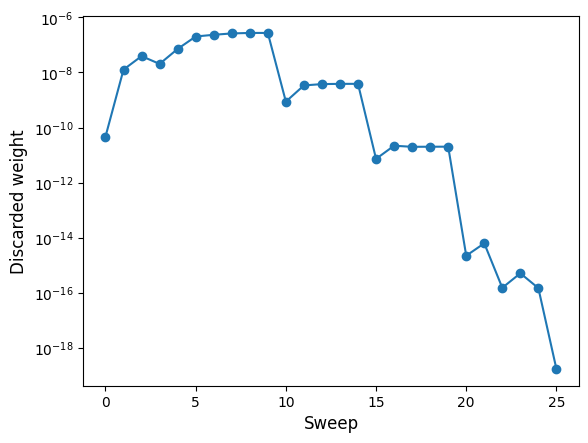

In [26]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

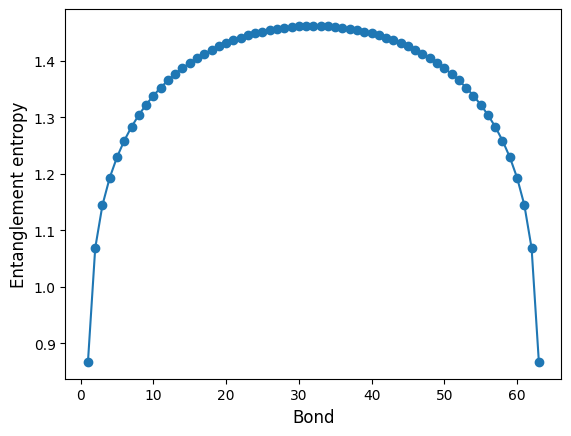

In [27]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [28]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='cd', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 63.99999999999964
Elapsed time: 9.224390029907227 seconds


### Site occupations

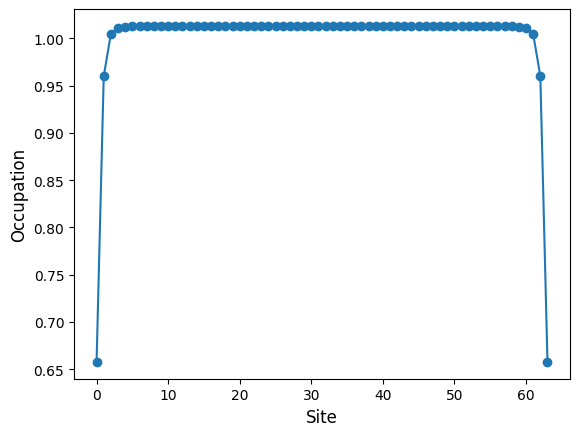

In [29]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

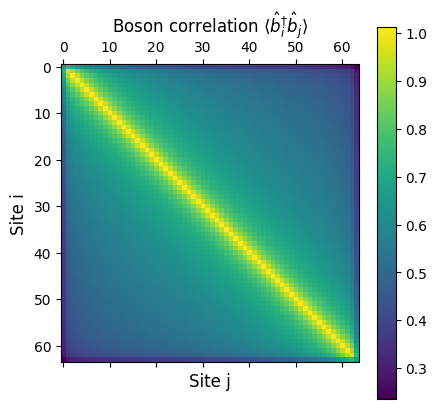

In [30]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

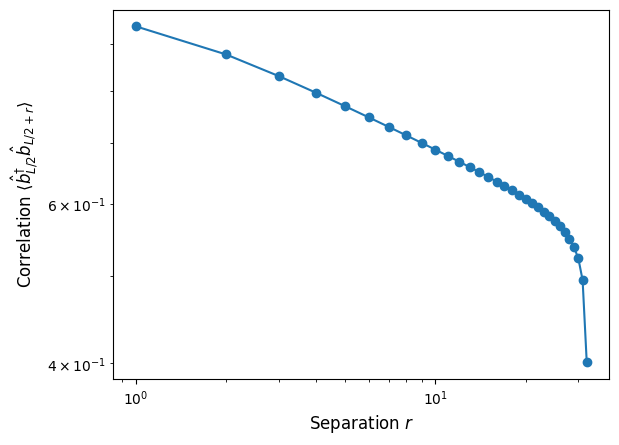

In [31]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

### Momentum distribution

Total number = 63.999999999999645


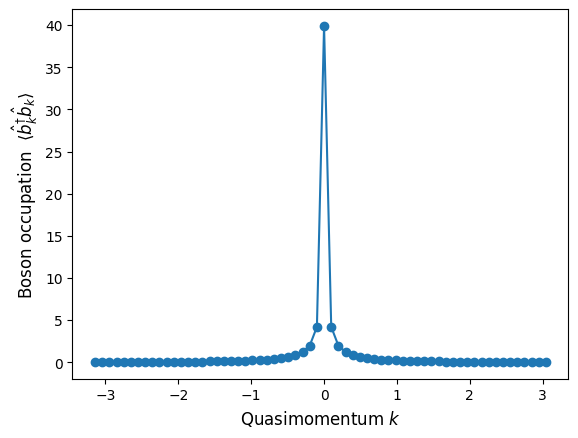

In [32]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
#plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

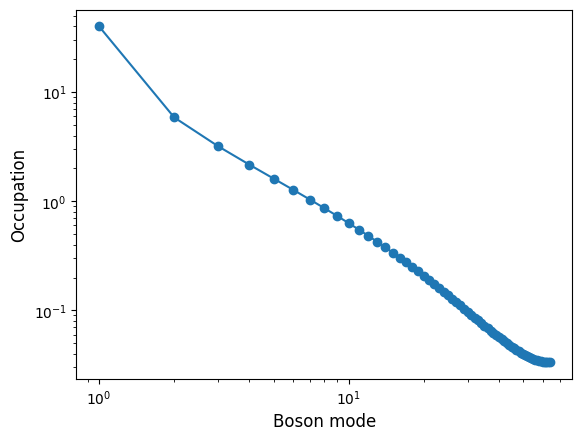

In [33]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(np.arange(1,L+1), bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [34]:
start_time = time.time()

ndist = []
for n in range(nmax+1):
    weights = driver.get_npdm(mps, npdm_expr=proj_keys[n], fermionic_ops='', mask=[0])[0]
    ndist.append(weights)
ndist = np.array(ndist).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 5.950836838078909e-14
Elapsed time: 26.771780967712402 seconds


### Site-averaged number distribution

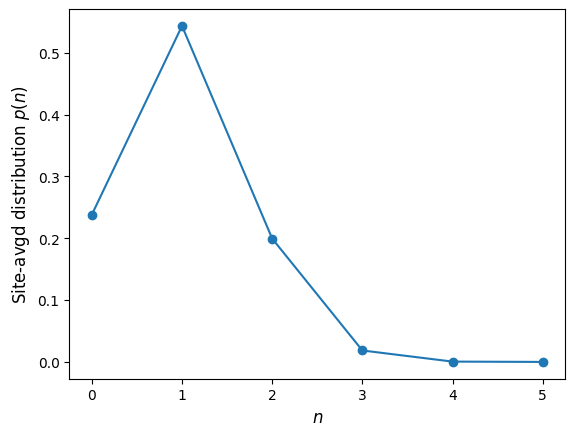

In [35]:
plt.plot(np.mean(ndist, axis=0), marker='o', label='Actual')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
#plt.plot([1/(np.e*math.factorial(n)) for n in range(nmax+1)], marker='o', label='Poisson')
#plt.legend()
plt.show()

### Number fluctuation

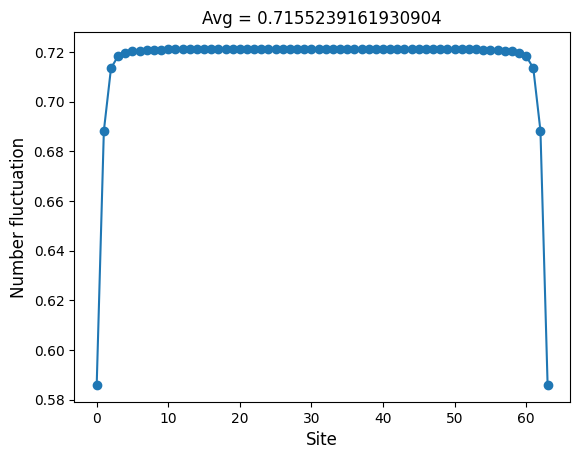

In [44]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [37]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='cdcd', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.7155239161930904
Elapsed time: 7.052588224411011 seconds


### Correlation matrix

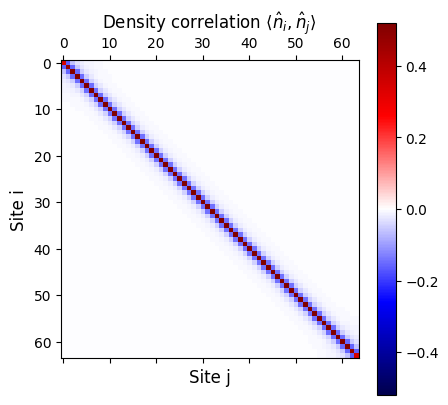

In [45]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

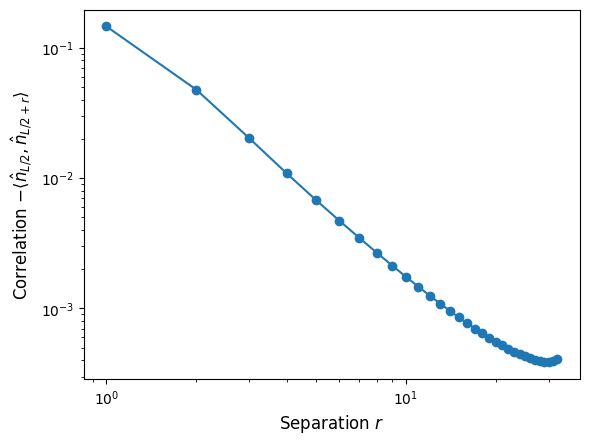

In [46]:
plt.plot(np.arange(1,L//2+1), -densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

# <font color='red'>Pseudofermion with $U/t=2$</font>

## <font color='blue'>Parameters</font>

In [65]:
L = 64
N = 64
t = 1.0
U = 2.0
nmax = 5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

## <font color='blue'>Local operators</font>

In [66]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

basis = [(Q(i), 1) for i in range(nmax + 1)]

bdag = np.diag([np.sqrt(n+1) for n in range(nmax)], -1)
b = bdag.T
adag = np.diag([np.sqrt(n+1) * (-1)**n for n in range(nmax)], -1)
a = adag.T
parity = np.diag([(-1.)**n for n in range(nmax+1)])
ops = {
    "": np.identity(nmax + 1), 
    "c": bdag, 
    "d": b, 
    "C": adag, 
    "D": a, 
    "P": parity
}

#proj_keys = ["P"+str(n) for n in range(nmax+1)]
proj_keys = ["Q","R","S","T","U","V","W","X","Y"][:nmax+1]
proj_ops = []
for n in range(nmax+1):
    proj_diag = np.diag(np.repeat([0, 1., 0], [n, 1, nmax-n]))
    proj_ops.append(proj_diag)
proj_dict = {}
for n in range(nmax+1):
    proj_dict[proj_keys[n]] = proj_ops[n]

for k in range(L): 
    site_basis.append(basis)
    site_ops.append(ops | proj_dict)

## <font color='blue'>Hamiltonian</font>

In [67]:
# [Part B] Set Hamiltonian terms
driver.initialize_system(n_sites=L, vacuum=Q(0), target=Q(N), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
os = driver.expr_builder()

for i in range(L-1):
    os.add_term("Cd", [i, i+1], -t)
    os.add_term("cD", [i+1, i], -t)
for i in range(L):
    os.add_term("ccdd", [i, i, i, i], U/2)

# [Part C] Perform DMRG
mpo = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

## <font color='blue'>DMRG</font>

In [68]:
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * L)
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())


Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.572 | E =     -51.2891814609 | DW = 6.48474e-09

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      4.828 | E =     -52.8149068367 | DE = -1.53e+00 | DW = 3.20286e-07

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      8.995 | E =     -53.7625021273 | DE = -9.48e-01 | DW = 6.41879e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     12.356 | E =     -54.5807464510 | DE = -8.18e-01 | DW = 3.38476e-07

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =     16.725 | E =     -54.6808641801 | DE = -1.00e-01 | DW = 5.99589e-07

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

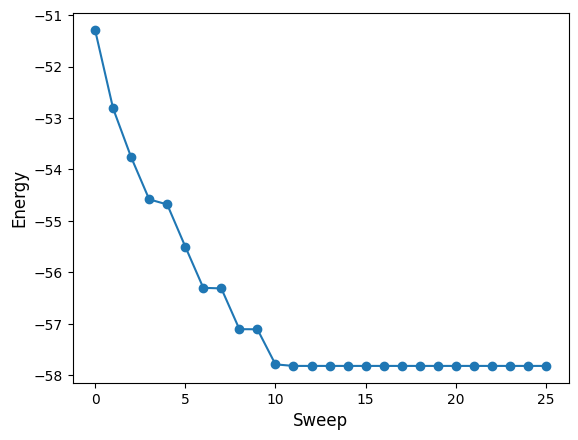

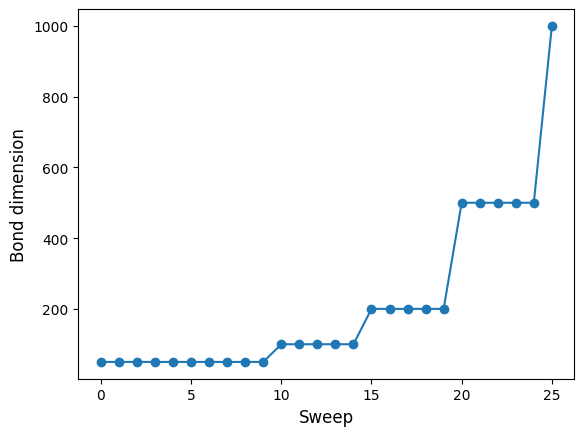

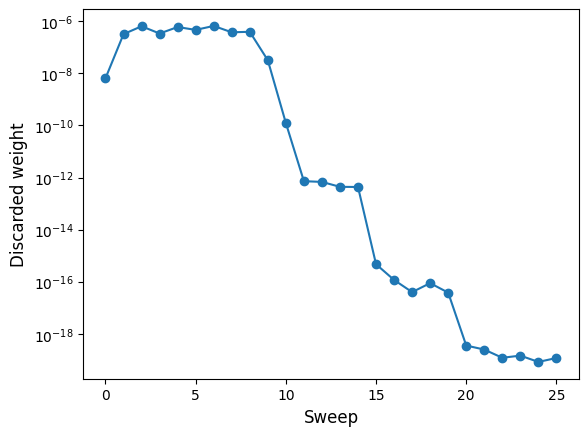

In [69]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

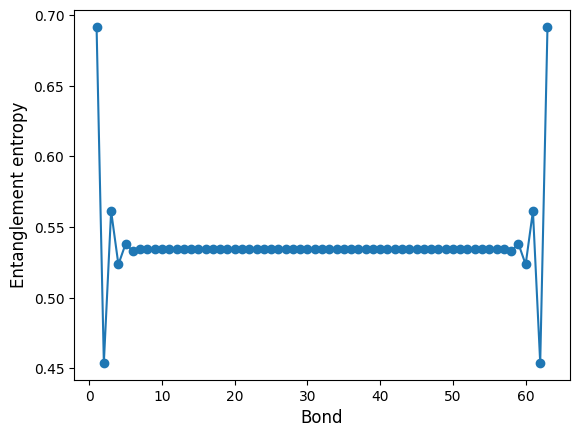

In [70]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,L), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [71]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='cd', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 63.99999999999939
Elapsed time: 6.052865028381348 seconds


### Site occupations

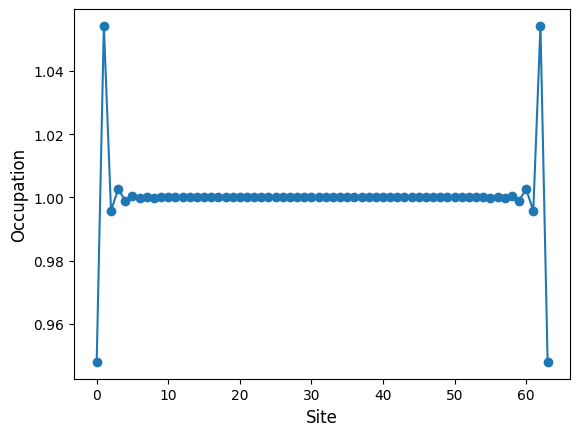

In [72]:
plt.plot(np.arange(L), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

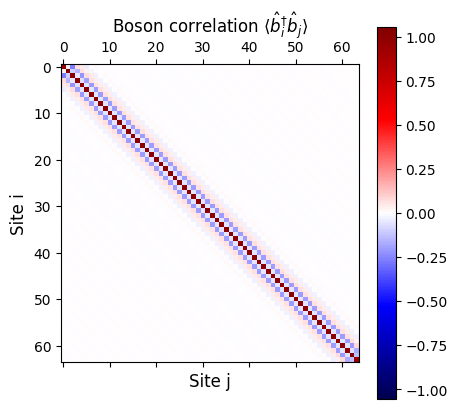

In [73]:
plt.matshow(bosoncorr_mat, cmap='seismic', vmin=-np.abs(bosoncorr_mat).max(), vmax=np.abs(bosoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

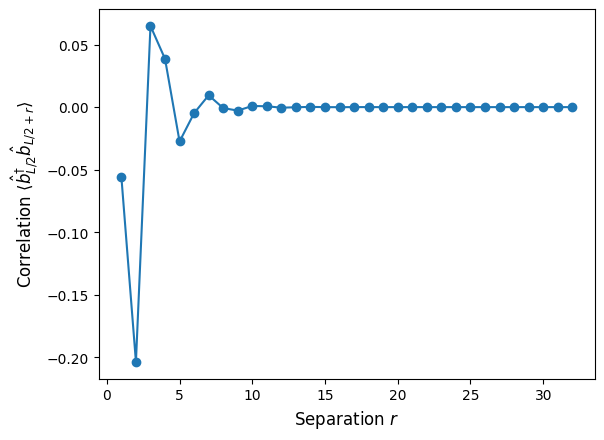

In [74]:
plt.plot(np.arange(1,L//2+1), bosoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.show()

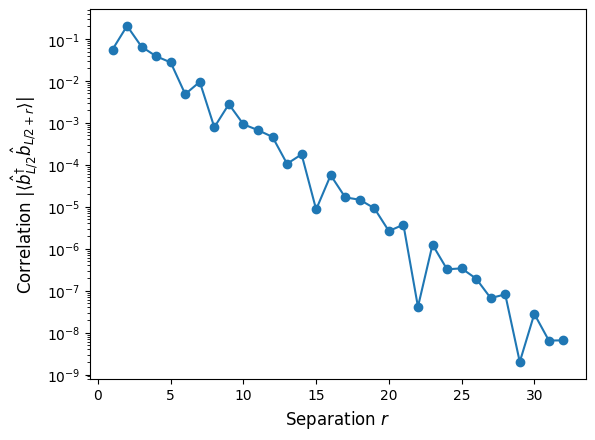

In [75]:
plt.plot(np.arange(1,L//2+1), abs(bosoncorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $|\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle|$', fontsize=12)
plt.yscale('log')
plt.show()

### Momentum distribution

Total number = 63.99999999999941


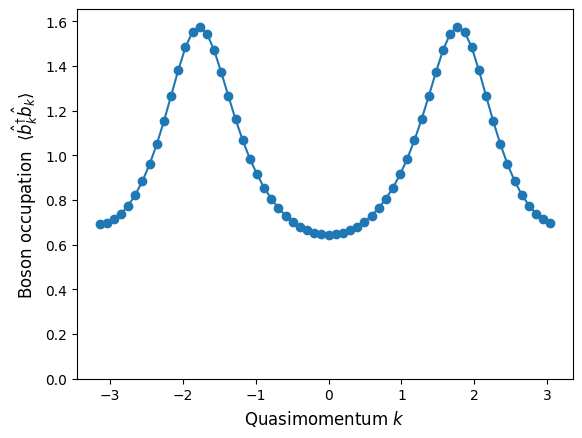

In [76]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
boson_momentum_corr = np.dot(np.dot(fourier, bosoncorr_mat), fourier_inverse)/L
boson_momentum_dist = np.real(np.diag(boson_momentum_corr))
print("Total number =", sum(boson_momentum_dist))

plt.plot(klist, boson_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Boson occupation  $\langle \hat{b}_k^{\dagger} \hat{b}_k \rangle$', fontsize=12)
plt.ylim(0, 1.05*max(boson_momentum_dist))
plt.show()

### Single-particle modes

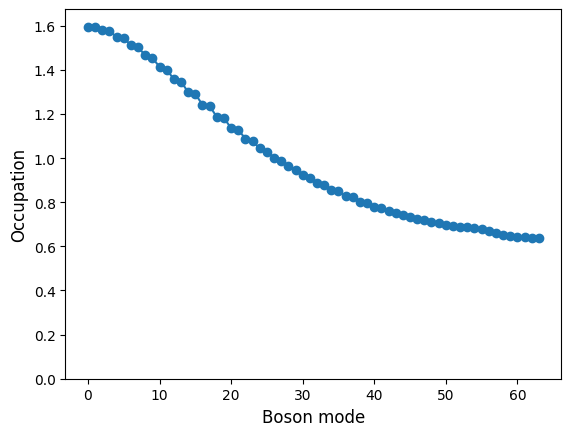

In [77]:
bosoncorr_eigvals = np.sort(np.linalg.eigvals(bosoncorr_mat))[::-1]
plt.plot(bosoncorr_eigvals, marker='o')
plt.xlabel('Boson mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.ylim(0, 1.05*max(bosoncorr_eigvals))
plt.yscale('linear')
plt.show()

## <font color='blue'>Single-particle anyon correlations</font>

### Calculate

In [78]:
start_time = time.time()

anyoncorr = []
for i in range(L):
    for j in range(i,L):
        os = driver.expr_builder().add_term("c"+"".join(["P"]*(j-i))+"d", [i] + list(range(i,j+1)), 1)
        op = driver.get_mpo(os.finalize(adjust_order=True, fermionic_ops=""))
        opexp = driver.expectation(mps, op, mps)
        anyoncorr.append(opexp)
anyoncorr_mat = vector_to_hermitian(anyoncorr)
print("Site occupation mismatch =", np.linalg.norm(navg - np.diag(anyoncorr_mat)))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Site occupation mismatch = 3.944433510943528e-14
Elapsed time: 412.0516128540039 seconds


### Correlation matrix

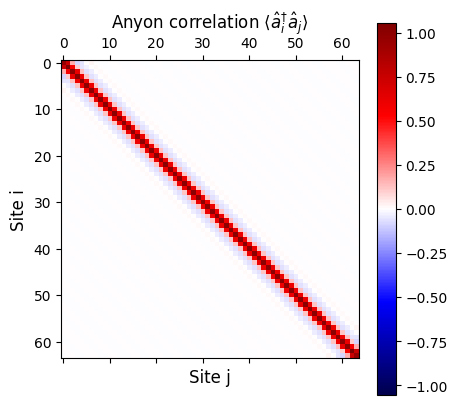

In [79]:
plt.matshow(anyoncorr_mat, cmap='seismic', vmin=-np.abs(anyoncorr_mat).max(), vmax=np.abs(anyoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Anyon correlation $\langle \hat{a}_{i}^{\dagger} \hat{a}_{j} \rangle$')
plt.show()

### Correlation vs distance

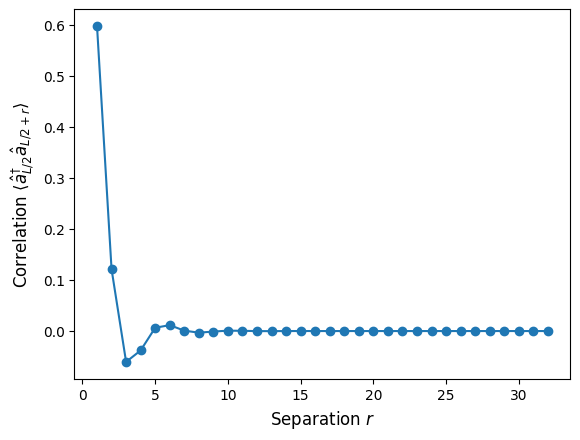

In [80]:
plt.plot(np.arange(1,L//2+1), anyoncorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{a}_{L/2}^{\dagger} \hat{a}_{L/2+r} \rangle$', fontsize=12)
plt.show()

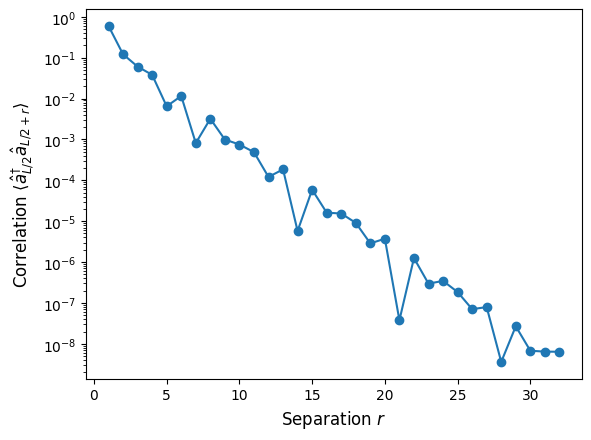

In [81]:
plt.plot(np.arange(1,L//2+1), abs(anyoncorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{a}_{L/2}^{\dagger} \hat{a}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.show()

### Momentum distribution

Total number = 63.99999999999968


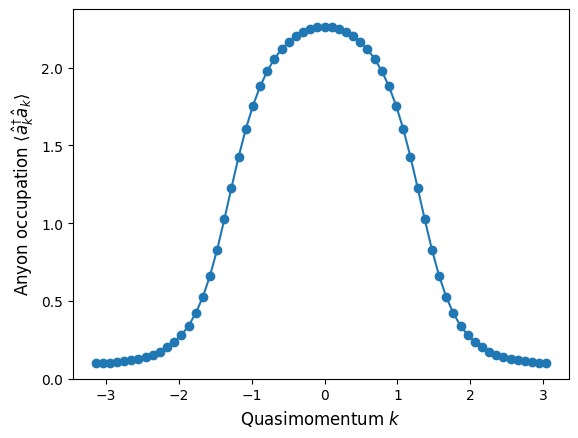

In [82]:
klist = (2*np.pi/L)*np.arange(-L//2,L//2)
fourier = np.array([[np.exp(1j*k*j) for j in np.arange(L)] for k in klist])
fourier_inverse = fourier.conj().T
anyon_momentum_corr = np.dot(np.dot(fourier, anyoncorr_mat), fourier_inverse)/L
anyon_momentum_dist = np.real(np.diag(anyon_momentum_corr))
print("Total number =", sum(anyon_momentum_dist))

plt.plot(klist, anyon_momentum_dist, marker='o')
plt.xlabel('Quasimomentum $k$', fontsize=12)
plt.ylabel(r'Anyon occupation $\langle \hat{a}_k^{\dagger} \hat{a}_k \rangle$', fontsize=12)
plt.ylim(0, 1.05*max(anyon_momentum_dist))
plt.show()

### Single-particle modes

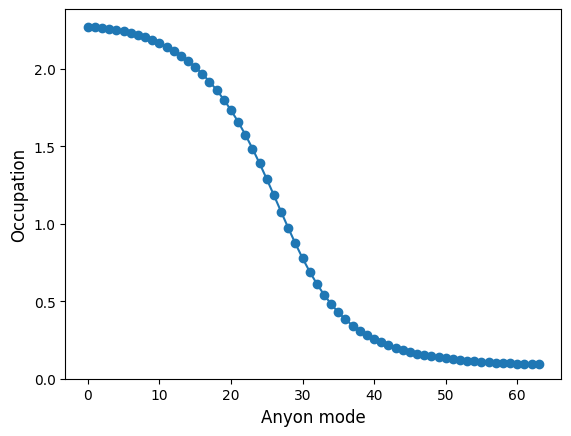

In [83]:
anyoncorr_eigvals = np.sort(np.linalg.eigvals(anyoncorr_mat))[::-1]
plt.plot(anyoncorr_eigvals, marker='o')
plt.xlabel('Anyon mode', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.ylim(0, 1.05*max(anyoncorr_eigvals))
plt.yscale('linear')
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [84]:
start_time = time.time()

ndist = []
for n in range(nmax+1):
    weights = driver.get_npdm(mps, npdm_expr=proj_keys[n], fermionic_ops='', mask=[0])[0]
    ndist.append(weights)
ndist = np.array(ndist).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(L)]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Deviation from unit filling = 7.818626922763081e-14
Elapsed time: 16.80599093437195 seconds


### Site-averaged number distribution

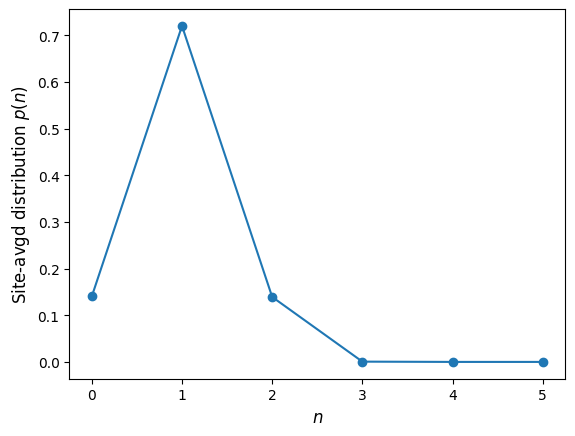

In [85]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuations

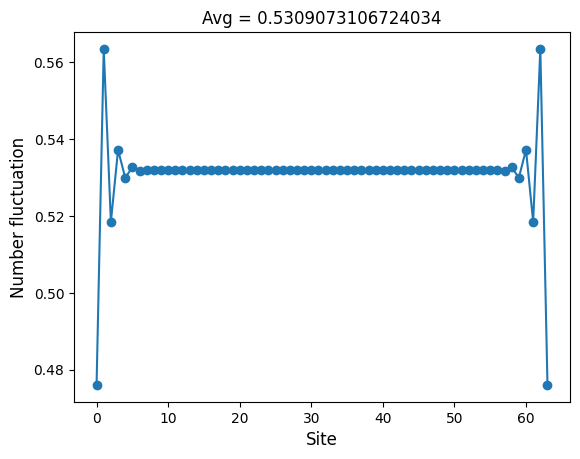

In [92]:
nsqavg = np.array([np.dot(np.arange(nmax+1)**2, ndist[i]) for i in range(L)])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(L), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [87]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='cdcd', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.5309073106724034
Elapsed time: 4.855013132095337 seconds


### Correlation matrix

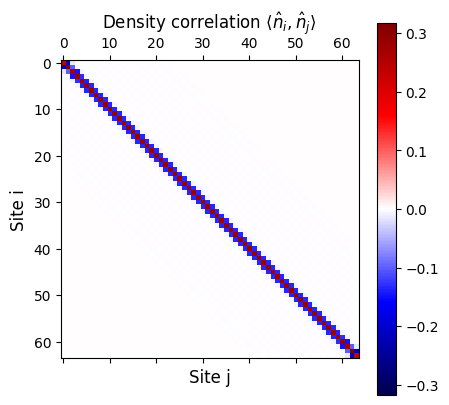

In [88]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

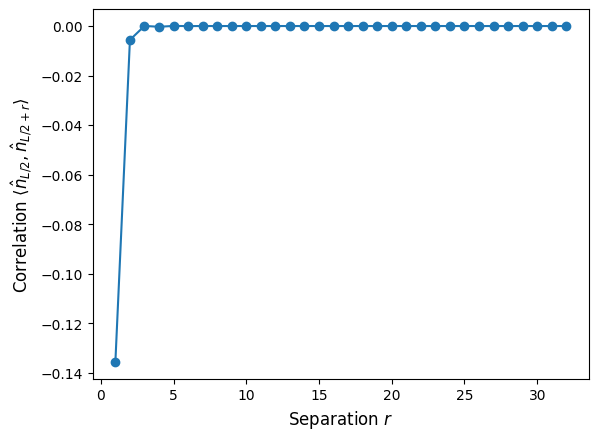

In [89]:
plt.plot(np.arange(1,L//2+1), densitycorr_mat[L//2-1,L//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.show()

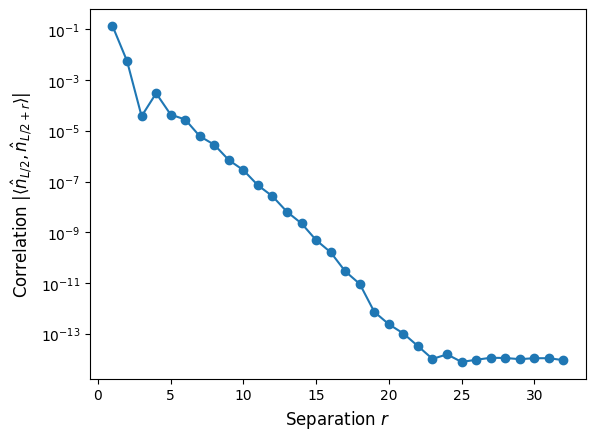

In [90]:
plt.plot(np.arange(1,L//2+1), abs(densitycorr_mat[L//2-1,L//2:]), marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $|\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle|$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()